In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb 

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

In [2]:
seed = 231094

# Machine Learning with XGBoost

XGBoost can be used for both supervised and unsupervised learning. 
- Supervised Classification/Regression
    - ROCAUC for binary
    - Accuracy, Confusion Matrix for multi
- Decision Trees

# Classification with XGBoost

In [3]:
breast_data = datasets.load_breast_cancer()

In [4]:
X = breast_data.data
y = breast_data.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [6]:
model = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 10, seed = seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

[10:28:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9649122807017544

## Boosting with XGBoost

Not exactly an algorithm. Its a meta-algorithm. Combines weak learners into much better learners by bringing them into one learner. 
- Accomplished by learning through weak learners. 
- Weighs each weak learner based on performance. 
- Combines those weighted predictions into a single prediciton. 

Cross-Validation is built into XGBoost

- Use XGBoost for:
    - Large number of trainign samples. Features < Samples
    - Mixture of cat or numeric, or just numeric

- Do not use for: 
    - Image, Comp Vision, NLP
    - Not good for small training sets. 

In [7]:
X, y

breast_dmatrix = xgb.DMatrix(X, y) # Optimised data structure specific to XGB. When using xgb.cv we need to make this
params = {
    'objective': 'binary:logistic', 
    'max_depth': 4
} # xgb.cv won't know what model we're using. 

cv_results = xgb.cv(dtrain = breast_dmatrix, params = params, nfold = 4, num_boost_round = 10, metrics = 'error', as_pandas = True, seed = seed)

cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.024602,0.007492,0.072060,0.012592
1,0.019922,0.006740,0.063245,0.017849
2,0.013470,0.006274,0.054479,0.020143
3,0.011128,0.004177,0.052706,0.018233
4,0.008785,0.003461,0.043928,0.021899
5,0.005856,0.003512,0.043916,0.020091
6,0.005856,0.003512,0.038659,0.020215
7,0.005271,0.003041,0.042168,0.023331
8,0.004684,0.003703,0.036898,0.017495
9,0.004098,0.003042,0.040419,0.018874


In [8]:
1 - cv_results['test-error-mean'].iloc[-1]

0.95958075

In [9]:
auc_results = xgb.cv(dtrain = breast_dmatrix, params = params, nfold = 4, num_boost_round = 10, metrics = 'auc', as_pandas = True, seed = seed)
auc_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.991135,0.007317,0.957643,0.010771
1,0.995277,0.002559,0.968277,0.016443
2,0.997163,0.002822,0.976878,0.015114
3,0.999068,0.000871,0.981764,0.014424
4,0.999281,0.000560,0.985923,0.011530
5,0.999424,0.000488,0.986485,0.011563
6,0.999675,0.000276,0.986590,0.011375
7,0.999748,0.000199,0.986459,0.011996
8,0.999822,0.000123,0.988343,0.009552
9,0.999903,0.000057,0.988173,0.009418


In [10]:
auc_results['test-auc-mean'].iloc[-1]

0.98817275

# Regession with XGBoost

Regression problems are predicting real values.
Metric is RMSE or MAE.
Algorithms are usually linear regression or decision trees. 

In [11]:
boston_data = datasets.load_boston()

In [12]:
X = boston_data.data
y = boston_data.target

Objective functions are hallmarks of regression algorithms. They quantify how far a prediciton is from the actual result. We try to minimise this function - to reduce loss. 

- reg:squarederror is for regression
- reg:logistic is for classification (not probability)
- binary:logistic is for classification (probability)

In [13]:
# Using trees as base learners

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

xg_tree = xgb.XGBRFRegressor(objective = 'reg:squarederror', n_estimators = 10, seed = seed)
xg_tree.fit(X_train, y_train)
y_preds = xg_tree.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
rmse

2.811734401565331

In [14]:
# Using linear base learners

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

train_DM = xgb.DMatrix(X_train, y_train)
test_DM = xgb.DMatrix(X_test, y_test)

params = {
    'booster':'gblinear',
    'objective':'reg:squarederror'
}

xg_reg = xgb.train(params = params, dtrain = train_DM, num_boost_round=10)
y_preds = xg_reg.predict(test_DM)

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
rmse

6.017262505902363

## Regularisation and Base Learners

Regularisation is a measure of model complexity. 
- gamma is for tree values. Minimum loss reduction allowed for a split to occur. 
- alpha is regularisation on leaf weights. High alpha drops large weights. L1.
- lambda smoother than L1. Doesn't drop. L2. 

In [15]:
# Using L1
boston_dm = xgb.DMatrix(X, y)

params = {
    'objective':'reg:squarederror',
    'max_depth':4
}

l1_params = [1, 10, 100]
rmse_l1 = []

for l1 in l1_params:
    params['alpha'] = l1
    cv = xgb.cv(dtrain = boston_dm, params = params, nfold = 4, num_boost_round = 10, metrics = 'rmse', as_pandas = True, seed = seed)
    rmse_l1.append(cv['test-rmse-mean'].tail(1).values[0])

results = list(zip(l1_params, rmse_l1))
pd.DataFrame(results, columns = ['l1', 'rmse'])

,l1,rmse
0,1,3.575130
1,10,3.742148
2,100,4.739748


## Extracting important Features

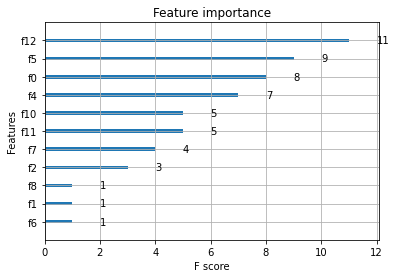

In [16]:
boston_dm
params

xg_model = xgb.train(dtrain = boston_dm, params = params, num_boost_round = 10)
xgb.plot_importance(xg_model)
plt.show()

# Fine Tuning and XGBoost Model

Why should we tune? 

In [22]:
X, y, boston_dm

(array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 31.6, 23.3, 19.6, 1

In [23]:
# Untuned
params = {
    'objective':'reg:squarederror'
}
untuned_model = xgb.cv(dtrain = boston_dm, params = params, nfold = 4, metrics = 'rmse', as_pandas = True, seed = seed)
untuned_model['test-rmse-mean'].tail(1)

9    3.518716
Name: test-rmse-mean, dtype: float64

In [36]:
# Tuned
params = {
    'objective':'reg:squarederror',
    'colsample_bytree':0.4,
    'learning_rate':0.1,
    'max_depth':5
}
tuned_model = xgb.cv(dtrain=boston_dm, params = params, nfold = 4, num_boost_round = 200, metrics = 'rmse', as_pandas = True, seed = seed)
tuned_model['test-rmse-mean'].tail(1)

199    3.387753
Name: test-rmse-mean, dtype: float64

In [37]:
# With early stopping
stop_model = xgb.cv(dtrain=boston_dm, params = params, nfold = 4, num_boost_round = 200, early_stopping_rounds = 10, metrics = 'rmse', as_pandas = True, seed = seed)
stop_model['test-rmse-mean'].tail(1)

105    3.386671
Name: test-rmse-mean, dtype: float64

## XGBoost Parameters

- Tree based:
    - learning_rate: How quickly the model fits residual error
    - gamma, alpha, lambda: Regularisation
    - max_depth: How deep each tree can grow per round
    - subsample: 0-1, How many samples of training data can be used per tree
    - colsample_bytree: 0-1, How many features can be used per tree

- Linear Based:
    - alpha, lambda, lambda-bias

In [50]:
# Learning Rate
X, y, boston_dm

lr_vals = [0.001, 0.01, 0.1]
rmse_vals = []
params = {
    'objective':'reg:squarederror',
    'max_depth': 3
}

for lr in lr_vals:
    params['learning_rate'] = lr
    model = xgb.cv(
        dtrain = boston_dm,
        params = params,
        early_stopping_rounds = 10,
        nfold = 3,
        num_boost_round = 10,
        as_pandas = True,
        metrics = 'rmse',
        seed = seed
    )
    rmse_vals.append(model['test-rmse-mean'].tail(1).values[-1])

pd.DataFrame(list(zip(lr_vals, rmse_vals)), columns=['Learning Rate', 'Error'])

,Learning Rate,Error
0,0.001,23.642105
1,0.010,21.721801
2,0.100,9.375521


In [49]:
# Tuning max_depth
X, y, boston_dm

params = {
    'objective':'reg:squarederror'
}
depths = [2, 5, 10, 20]
rmse_vals = []

for depth in depths: 
    params['max_depth'] = depth
    model = xgb.cv(
        dtrain = boston_dm,
        params = params,
        early_stopping_rounds = 10,
        nfold = 3,
        num_boost_round = 10,
        as_pandas = True,
        metrics = 'rmse',
        seed = seed
    )
    rmse_vals.append(model['test-rmse-mean'].tail(1).values[-1])

pd.DataFrame(list(zip(depths, rmse_vals)), columns = ['Depth', 'Error'])

,Depth,Error
0,2,4.126482
1,5,3.622287
2,10,3.693062
3,20,3.706704


Can also use GridSearch and RandomSearch with XGBoost!

In [53]:
# Grid Search
X, y, boston_dm

param_grid = {
    'learning_rate':[0.01, 0.03, 0.1, 0.3],
    'n_estimators':[100, 200],
    'subsample':[0.3, 0.5, 0.7]
}

model = xgb.XGBRFRegressor()
grid_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'neg_mean_squared_error')
grid_model.fit(X, y)
print('Best Parameters', grid_model.best_params_)
print('Lowest RMSE', np.sqrt(np.abs(grid_model.best_score_)))

Best Parameters {'learning_rate': 0.3, 'n_estimators': 100, 'subsample': 0.5}
Lowest RMSE 17.080337446009906


In [57]:
# Random Search
X, y, boston_dm

param_grid = {
    'learning_rate':[0.01, 0.03, 0.1, 0.3],
    'n_estimators':[100, 200],
    'subsample':[0.3, 0.5, 0.7]
}

model = xgb.XGBRFRegressor()
grid_model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'neg_mean_squared_error', n_iter = 25)
grid_model.fit(X, y)
print('Best Parameters', grid_model.best_params_)
print('Lowest RMSE', np.sqrt(np.abs(grid_model.best_score_)))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=25. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters {'subsample': 0.5, 'n_estimators': 100, 'learning_rate': 0.3}
Lowest RMSE 17.080337446009906


# Pipelines and XGBoost

In [64]:
X, y

steps = [
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
]

rf_pipe = Pipeline(steps)

scores = cross_val_score(rf_pipe, X, y, scoring = 'neg_mean_squared_error', cv = 10)
rmse = np.mean(np.sqrt(np.abs(scores)))
rmse # Off by four units

4.233548610447237

One issue with pipelines is we can't use a label encoder or OneHotEncoding with the pipeline.
It must be done before the pipeline begins. We can use a DictVectorizer instead. 

In [75]:
dv = DictVectorizer(sparse = False)
X_dict = pd.DataFrame(X).to_dict('records') # Must first be converted from a df to a dict
dv.fit_transform(X_dict)

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

In [76]:
# To use xgboost

steps = [
    ('scaler', StandardScaler()),
    ('encoder', DictVectorizer()),
    ('xgb_model', xgb.XGBRFRegressor()) # Only difference!
]